# 3-SAT con Grover:




El problema de **boolean satisfiability**, a veces llamado **SAT** o **B-SAT**, consiste en determinar si las variables de una fórmula booleana se pueden reemplazar por TRUE o FALSE de forma que la expresión sea TRUE. Es decir, verificar que una fórmula es satisfacible.

Un *literal* es una variable o la negación de una variable (literal positivo o negativo). Una cláusula es una disyunción de literales o un único literal. Por ejemplo, $C = \lnot x_1$ y $C = x_1 \lor x_2 \lor \lnot x_3$ son ejemplos de cláusulas. Una fórmula está en *Forma normal conjuntiva* si es una conjunción de cláusulas (AND lógico conectando las cláusulas) o una única cláusula. Por ejemplo:

$$(x_1 \lor \lnot x_2) \land (x_2 \lor x_4 \lor \lnot x_5)$$

En general, escribimos:

$$C_1 \land C_2 \dots \land C_n$$

En el 3-SAT, queremos determinar si una fórmula en CNF se puede satisfacer, donde cada cláusula está limitada a, como máximo, 3 variables. Por ejemplo:

$$F(x_1, x_2, x_3) = (x_1 \lor x_2 \lor x_3) \land (x_1 \lor x_2 \lor \lnot x_3) \land (x_1 \lor \lnot x_2) \Rightarrow F(\text{TRUE}, \text{FALSE}, \text{FALSE}) = \text{TRUE}$$

Ejemplo de instancia sin solución:

$$F(x_1, x_2) = (x_1 \lor x_2) \land (\lnot x_1 \lor x_2) \land (x_1 \lor \lnot x_2) \land (\lnot x_1 \lor \lnot x_2)$$



In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.primitives import StatevectorSampler
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import ZGate, XGate

import math

In [12]:
# Define instance of 3-SAT. 
instance = [
    [1, 2, 3],      # x1 ∨ x2 ∨ x3
    [1, 2, -3],     # x1 ∨ x2 ∨ ¬x3
    [1, -2, 3],     # x1 ∨ ¬x2 ∨ x3
    [1, -2, -3],    # x1 ∨ ¬x2 ∨ ¬x3
    [-1, 2, 4],     # ¬x1 ∨ x2 ∨ x4
    [-1, -2, 4],    # ¬x1 ∨ ¬x2 ∨ x4
    [-1, 2, -4],    # ¬x1 ∨ x2 ∨ ¬x4
    [-1, -2, 3],    # ¬x1 ∨ ¬x2 ∨ x3
]
variables = max(max([abs(k) for k in clause] for clause in instance))
total_clauses = len(instance)
print(f" > Variables: {variables}")
print(f" > Clauses: {total_clauses}")

 > Variables: 4
 > Clauses: 8


In [43]:
def check_solution(sol):
    # Check if a binary vector of len = 'variables' is a solution of the instance
    for clause in instance:
        clause_true = False
        for q in clause:
            clause_true = clause_true or ((sol[abs(q) - 1] == 0 and q < 0) or (sol[abs(q) - 1] == 1 and q > 0))

        if not clause_true:
            return False

    return True

# Solve the problem by checking all posible binary vectors of len = 'variables'
total_solutions = 0
for i in range(2**variables):
    bin_string = bin(i)[2::]
    bin_string = '0'*(variables - len(bin_string)) + bin_string
    
    sol = [int(b) for b in bin_string]

    check_sol = check_solution(sol)
    if check_sol:
        total_solutions += 1
        print(f" > Check solution: {sol}: {check_sol}")

print(f" > Total solutions: {total_solutions}")
grover_iterations = round(math.acos( math.sqrt(total_solutions)/math.sqrt(2**variables) )/( 2*math.asin( math.sqrt(total_solutions)/math.sqrt(2**variables) ) ) - 1e-6)
print(f" > Iterations for Grover: {grover_iterations}")

 > Check solution: [1, 1, 1, 1]: True
 > Total solutions: 1
 > Iterations for Grover: 3


In [44]:
def oracle1(qc, qr, qubits_list = None):
    '''
    Append the Grover oracle of the 3-SAT to a quantum circuit qc.
    This oracle uses phase-kickback

    Args:
        - qc (QuantumCircuit): Qiskit Quantum Circuit
        - qr (QuantumRegister): Qiskit Quantum Register in which to apply the oracle
        - qubits_list (int[]): list that indicates the order of the qubits. If None we select the natural order (From zero to the amount of qubits in qr)

    Returns:
        - None
    '''

    if (qubits_list == None):
        qubits_list = [i for i in range(len(qr))]

    n = len(qubits_list)
    principal_qubits = qubits_list[0:variables]
    ancillas = qubits_list[variables:variables+total_clauses]
    pkb_qubit = qubits_list[n-1]


    for i, clause in enumerate(instance):
        qc.barrier()
        for q in clause:
            if q < 0:
                qc.x(principal_qubits[abs(q) - 1])

        qc.x([principal_qubits[abs(q) - 1] for q in clause] + [ancillas[i]])


        qc.append(XGate().control(3), [principal_qubits[abs(q) - 1] for q in clause] + [ancillas[i]])

        qc.x([principal_qubits[abs(q) - 1] for q in clause])


        for q in clause:
            if q < 0:
                qc.x(principal_qubits[abs(q) - 1])

        qc.barrier()

    
    qc.append(XGate().control(total_clauses), ancillas + [pkb_qubit])

    # Inverse to set ancillas in 0 again
    for j, clause in enumerate(instance[::-1]):
        i = len(instance) - j - 1
        qc.barrier()
        for q in clause:
            if q < 0:
                qc.x(principal_qubits[abs(q) - 1])

        
        qc.x([principal_qubits[abs(q) - 1] for q in clause])

        qc.append(XGate().control(3), [principal_qubits[abs(q) - 1] for q in clause] + [ancillas[i]])

        qc.x([principal_qubits[abs(q) - 1] for q in clause] + [ancillas[i]])

    

        for q in clause:
            if q < 0:
                qc.x(principal_qubits[abs(q) - 1])

        qc.barrier()
    
    return




def grover(qc, qr, oracle_f, ancilla = None, iterations = None, qubits_list = None):
    '''
    Append the Grover algorithm circuit to a quantum circuit qc. Assuming that all qubits start at |0>

    Args:        
        - qc (QuantumCircuit): Qiskit Quantum Circuit
        - qr (QuantumRegister): Qiskit Quantum Register in which to apply the Grover operator
        - oracle_f: Function that appends the oracle to the circuit. Receives a QuantumCircuit, a QuantumRegister, and a qubits_list
        - ancilla (QuantumRegister): Quantum Register for the ancilla qubits. Might be more than just one qubit if the oracle needs extra auxiliary qubits
        - iterations (int): Number of iterations to apply. If None, apply one iteration
        - qubits_list (int[]): list indicating the order of the qubits. If None, the natural order is used (from zero to the number of qubits in qr)

    Returns: 
        - None
    '''

    if not iterations:
        iterations = 1

    if (qubits_list == None):
        qubits_list = [i for i in range(len(qr))]

    n = len(qubits_list)

    # Estado inicial de la ancilla
    if ancilla:
        qc.x(ancilla[-1])
        qc.h(ancilla[-1])

    # Estado inicial del registro principal
    qc.h(qubits_list)
    
    for _ in range(iterations):
        qc.barrier()
        # Agregar oraculo O_f
        if ancilla:

            oracle_f(qc, qubits_list + [anc for anc in ancilla])
        else:
            oracle_f(qc, qubits_list)
        qc.barrier()

        # Agregar operador de difusión:
        qc.h(qubits_list)
        qc.x(qubits_list)
        qc.append(ZGate().control(n - 1), qubits_list)
        qc.x(qubits_list)
        qc.h(qubits_list)

### Test del oráculo: 

Vamos a testear el oráculo para un estado aleatoreo de la base computacional. 

Si $F(\text{test\_state}) = \text{True}$ entonces el último qubit (el qubit de la izquierda al medir) debe estar en 1. En otro caso el qubit se debería medir en 0.

In [40]:
# Test oracle in random test_state
import random

qubit_count = variables
qr = QuantumRegister(qubit_count, 'q')
cr = ClassicalRegister(qubit_count, 'c')
ancilla = QuantumRegister(1 + total_clauses, 'a')
qc = QuantumCircuit(qr, ancilla, cr)

test_state = [random.randint(0, 1) for _ in range(variables)] 
for i, state in enumerate(test_state[::-1]):
    if state == 1:
        qc.x(qr[i])

oracle1(qc, [q for q in qr] + [q for q in ancilla])

In [42]:
qc.measure_all()

# Instanciar Statevector
sampler = StatevectorSampler()
shots = 100000
 

job = sampler.run([qc], shots=shots)
 
# Extract the result for the 0th pub (this example only has one pub).
result = job.result()[0]
counts = result.data.meas.get_counts()

print(f"Oracle output in a computational basis state test_state = {test_state}: {counts}")
print(f"F(test_state) = {check_solution(test_state[::-1])}")

Oracle output in a computational basis state test_state = [0, 1, 1, 0]: {'0000000000110': 100000}
F(test_state) = False


### Implementación de Grover

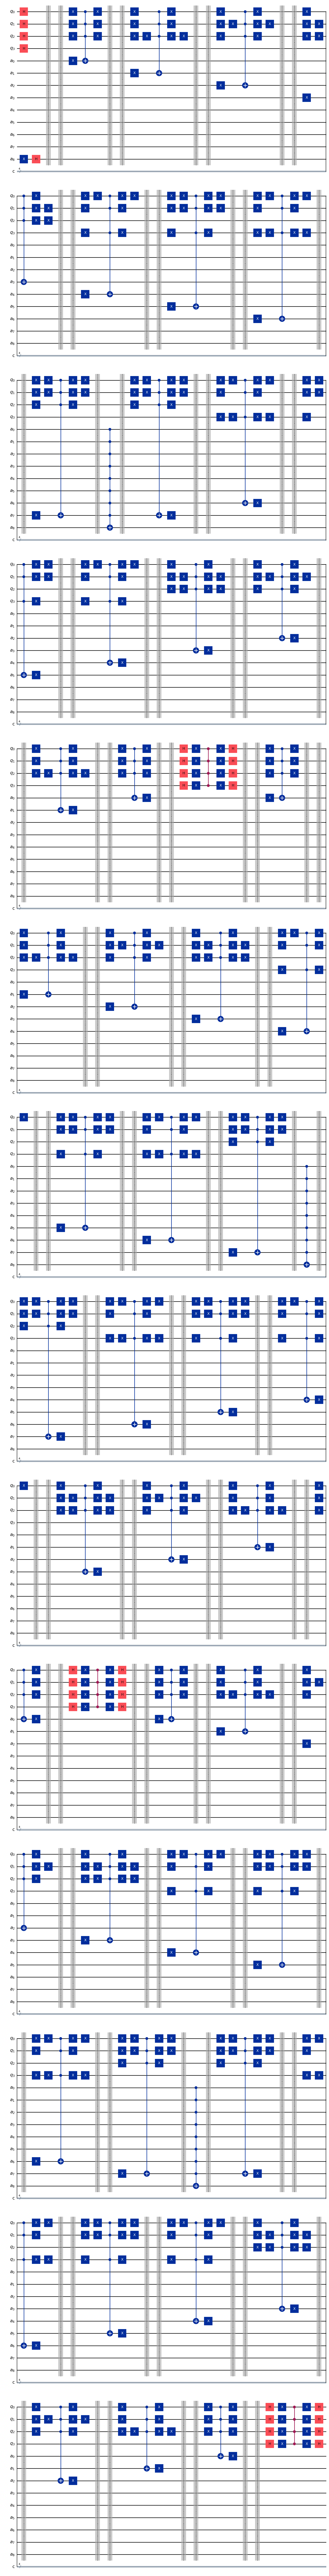

In [37]:
# Generate a circuit with the optimum number of Grover iterations
qubit_count = variables
qr = QuantumRegister(qubit_count, 'q')
cr = ClassicalRegister(qubit_count, 'c')
ancilla = QuantumRegister(1 + total_clauses, 'a')
qc = QuantumCircuit(qr, ancilla, cr)


grover(qc, qr, oracle1, ancilla=ancilla, iterations=grover_iterations)

qc.draw("mpl")

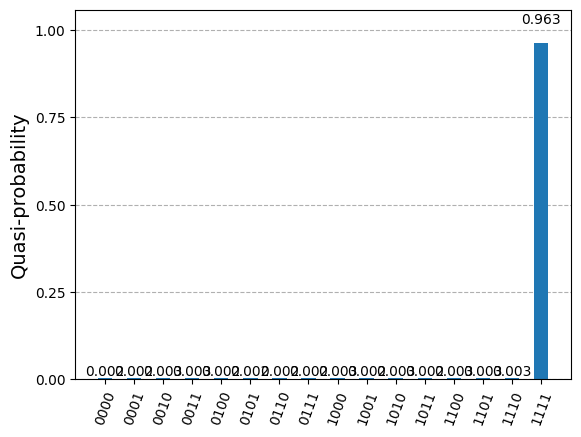

In [38]:
qc.measure(qr, cr)

sampler = StatevectorSampler()
shots = 100000
 

job = sampler.run([qc], shots=shots)
 
# Extract the result for the 0th pub (this example only has one pub).
result = job.result()[0]
counts = result.data.c.get_counts()

probs = {}
for key in counts.keys():
    probs[key] = counts[key]/shots

plot_histogram(probs)